In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as sps

In [129]:
from bs4 import BeautifulSoup

In [130]:
path = "~/isomirs/Bimodal_mir22/"
df = pd.read_csv(path+'isomiR_CPM.tsv', sep = '\t')
mir22 = df.loc["hsa-miR-22-3p|+1|0"]
cond_cancer = df.columns.str.contains('-0[1-9][A-Z]', regex = True)
df_cancer = df[df.columns[cond_cancer]]

**1. Батч-эффект, связанный с TSS.**
- Распределение 0/1/2 (одномодально, двумодально) по TSS и разным ракам (2 - бимодально; 1 - выше 11; 0 - ниже 11)
- Есть ли бимодальность вне TCGA? Найти miRNA-seq выборки пациентов какого-то рака.

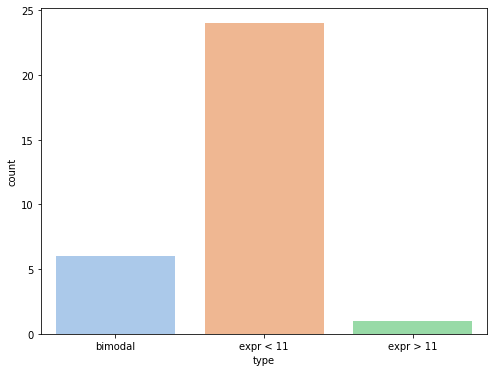

In [131]:
dict_canc = {'bimodal': ['BRCA', 'COAD', 'HNSC', 'LUAD', 'LUSC', 'READ', 'UCEC'],
            'expr > 11': ['KIRC'],
            'expr < 11': ['ACC', 'BLCA', 'CESC', 'CHOL', 'DLBC', 'ESCA',
               'KICH', 'HNSC', 'KIRP', 'LGG', 'LIHC', 'MESO',
               'OV', 'PAAD', 'PCPG', 'PRAD', 'SARC', 'SKCM',
               'STAD', 'TGCT', 'THCA', 'THYM', 'UCS', 'UVM']}
df = pd.DataFrame()
for i, j in dict_canc.items():
    for gene in j:
        df[gene] = [i]
df = df.T
df.columns = ['type']
plt.figure(figsize = (8, 6))
sns.countplot(data = df, x = 'type', palette = 'pastel')
plt.show()

In [132]:
# HNSC, KIRC, STAD, LUAD -  c маленькими вторыми горбами

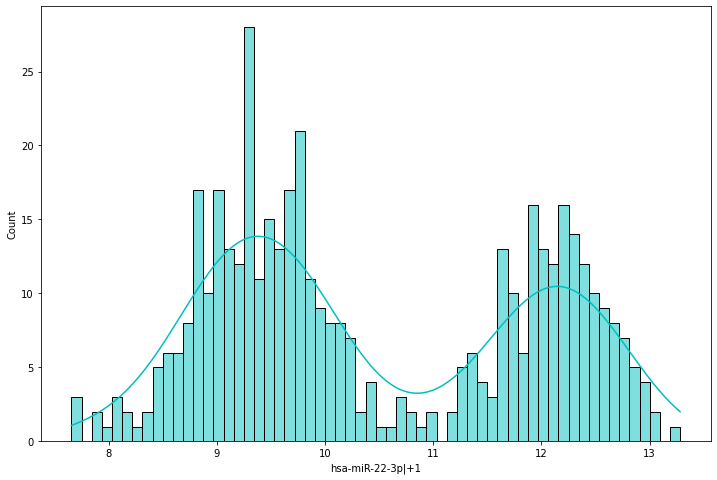

In [176]:
cond_cancer = COAD.columns.str.contains('-01[A-Z]', regex = True)
COAD = pd.read_csv("COAD_isomiR_5prime_CPM.tsv", sep = '\t')
COAD_22_all = COAD.loc["hsa-miR-22-3p|+1"]
COAD = COAD[COAD.columns[cond_cancer]]
COAD_22 = COAD.loc["hsa-miR-22-3p|+1"]

plt.figure(figsize = (12, 8))
sns.histplot(COAD_22, bins = 60, kde = True, color = 'c')
plt.show()

In [177]:
def annotation(table, miRNA, name):
    cond = miRNA < 11
    left, right = miRNA[cond], miRNA[~cond]
    left_sample, right_sample = table[left.index], table[right.index]
    row = list(['left' if i in left else 'right' for i in table.columns])
    ann = pd.DataFrame(row, index = table.columns, columns = ['Tissue'])
    ann.to_csv('annotation'+name+'.tsv', sep = '\t')
    return ann, left, right

In [192]:
def get_table_corr(table_gene, name_gene, mir):
    gene = []
    corr_p, p_p = [], []
    corr_sp, p_sp = [], []
    for i in name_gene:
        try:
            g = table_gene.loc[i]
            gene.append(i)
            corr_p.append(sps.pearsonr(g, mir)[0])
            corr_sp.append(sps.spearmanr(g, mir)[0])
            p_p.append(sps.pearsonr(g, mir)[1])
            p_sp.append(sps.spearmanr(g, mir)[1])
        except:
            pass
    corr_table = pd.DataFrame([gene, corr_p, p_p, corr_sp, p_sp],
                              index = ['Gene name', 'pearson corr', 'pearson p', 'spearman corr', 'spearman p']).T
    return corr_table, gene

In [178]:
ann_COAD, left_COAD, right_COAD = annotation(COAD, COAD_22, '_COAD')

In [179]:
# gene_counts = pd.read_csv('COAD_gene_counts.tsv', sep = '\t', index_col = 0)
# cancer_counts = gene_counts[gene_counts.columns[cond_cancer]]
# cancer_counts.to_csv('COAD_cancer_counts.tsv', sep = '\t')

In [180]:
cond = lambda i: (i['baseMean'] > 1000) & (i['padj'] < 0.05) & (abs(i['log2FoldChange']) > 1)
data_cancer = pd.read_csv('COAD_gene_deseq2.tsv', sep = '\t').dropna()
target_COAD = data_cancer.loc[cond]
target_COAD['Gene name'] = target_COAD.index

<ipython-input-180-3c915791cd2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_COAD['Gene name'] = target_COAD.index


In [181]:
types = pd.read_fwf('mart_export.txt', delimiter = '\t')
types = types['Gene type\tGene name'].str.split('\t', expand = True)
types.columns = ['Gene type', 'Gene name']

table = pd.merge(types, target_COAD, how='left', on='Gene name')
table = table.reindex(
            columns=['Gene name', 'baseMean','log2FoldChange',
            'lfcSE', 'pvalue', 'padj', 'Gene type'])
table = table.dropna()

In [211]:
genes = pd.read_csv('COAD_gene_FPKM.tsv', sep = '\t')
left_sample_gene, right_sample_gene = genes[left_COAD.index], genes[right_COAD.index]
corr_table, gene = get_table_corr(genes, target_COAD.index, COAD_22_all)

In [212]:
itog_table = pd.merge(table, corr_table, how='left', on='Gene name')
itog_table.sort_values(by = "pearson corr", key = abs, ascending = False).to_csv('COAD_diff_genes_corr.tsv')

In [209]:
# for i in gene:
#     print(i)

**2. Губки lncRNA забирают на себя miR-22|+1.**
- Какие lncRNA имеют сайты посадки микроРНК miR-22|+1, но не miR-22|0?
- Сделать анализ дифф экспрессии по всем ракам

**3. RNA-binding proteins (RBP) связываются с miR-22 и подавляют/активируют создание неканонической изоформы.**
- Какие RBP могут связываться с pri-mir-22?
- Попадают ли эти RBP в список дифф экспрессированных?